# Summary

Exploration of a geomorphic Hamiltonian for hillslopes & rockslopes.

The basic premise is that surface-normal erosion takes place at a rate (speed) $\xi^{\perp}$ dependent only on surface angle $\beta$. 
This rate is modelled as an exponential activation function of the form
\begin{equation}
    \xi^{\perp}(\beta) = \xi^{\perp_0}  \exp\!\left[1- \left(\dfrac{\sin\phi}{|\sin\beta|}\right)^{\!n\,} \right]
\end{equation}

where $\phi$ is a reference threshold angle, $n$ is a hack to control the abruptness of the switch from low to high erosion rates with angle $\beta$, and $\xi^{\perp_0}$ is a base erosion rate. A model variation employs a $\tan$ rather than $\sin$ function. See the "Erosion function" section for demo plots of the erosion model.

This model states that surface-normal erosion of a hillslope/rockslope is essentially zero for surface angles $\beta \lesssim \phi$ and fast for $\beta \gtrsim \phi$. 

[THIS PART NEEDS UPDATING] This notebook uses SymPy to derives the following:

1. the fundamental function $\mathcal{F}_*(\mathbf{r},\mathbf{p})$ corresponding to this slope erosion model
2. the subsequent geomorphic Hamiltonian $\mathcal{H}(\mathbf{r},\mathbf{p})$
3. Hamilton's ray tracing equations $\dot{\mathbf{r}}$ and $\dot{\mathbf{p}}$
4. the critical angle(s) at which the Hessian of $\mathcal{H}(\mathbf{r},\mathbf{p})$ is singular, which is where (at what slope angle $\beta$) the link between the Hamiltonian and Lagrangian spaces is broken, and where we see a transition from convexity to concavity.

It then plots the following:

1. the shape of the normal slowness figuratrix $\mathcal{F}_*(\mathbf{r},\mathbf{p}) = 1$
2. the the ray velocity indicatrix $\mathcal{F}(\mathbf{r},\mathbf{v})=1$

annotated to highlight any convexo-concavity.

We find that for the $\sin$ model (for all $n$) the figuratrix and indicatrix are always convexo-concave. For smaller values of $n$, convexity is seen for $\beta < \beta_{\mathrm{crit}}$, and concavity for $\beta> \beta_{\mathrm{crit}}$; the transition correlates with the erosion threshold, with $\beta_{\mathrm{crit}} \approx \phi$.  This is also true for the $\tan$ model, except for $n=1$, when the figuratrix and indicatrix are fully convex. Rays always point obliquely *up*. 

For larger $n$ (more abruptly step-like erosion function, for which $\beta_{\mathrm{crit}} \rightarrow \phi$), and for both $\sin$ and $\tan$ models, there is a second concave portion of the figuratrix and indicatrix for steeper $\beta$. Rays point obliquely *down* over this range.

These results suggests that cusp formation will take place as an initial slope profile evolves, with more complexity for sharper (higher $n$) erosion threshold behaviour. Ray traced solutions are needed to investigate this further.

One result is clear, however. Since $\mathcal{H}(\mathbf{r},\mathbf{p})$ is actually just a function of slowness, i.e., we have $\mathcal{H}(\mathbf{p})$, Hamilton's equations for the rate of change of slowness are zero, $\dot{\mathbf{p}} = \mathbf{0}$. 

   * This means that the eikonal rays are ***straight lines***. 
    
Predicting evolution from an arbitrarily shaped initial profile should therefore be quite straightforward.

# Preliminaries

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    # pr_filenames = ['Hillslope_sinbeta_phi45_n4']
    # pr_filenames = ['Hillslope_sinbeta_phi45_n10']
    # pr_filenames = ['Hillslope_sinbeta_phi45_n20']
    # pr_filenames = ['Hillslope_tanbeta_phi45_n1']
    # pr_filenames = ['Hillslope_tanbeta_phi45_n2']
    # pr_filenames = ['Hillslope_tanbeta_phi45_n5']
    pr_filenames = ['Hillslope_tanbeta_phi45_n10']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [3]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
import sympy as sy
from sympy import (
    Eq,
    lambdify,
    sin,
    cos,
    sec,
    Rational,
    sqrt,
    solve,
    N,
    init_printing,
    trigsimp,
    expand,
    rad,
    Symbol,
    Function,
    exp,
    tan,
    asin,
    Abs,
    simplify,
    diff,
    Matrix,
    powsimp,
    factor,
    denom,
    numer,
    re,
    im,
    det,
)
from sympy.simplify.fu import TR2

# Set up latex inline printing
init_printing(use_unicode=True, pretty_print=True, wrap_line=True)

# Pretty dict printing etc
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot import GraphingBase

from matplotlib import pyplot as plt

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
# from gme.core.symbols import *
from gme.core.symbols import (
    xi_h0,
    xi_h,
    n_h,
    phi,
    alpha,
    # beta,
    beta_crit,
    Fstar,
    H,
    lmbda,
    rdotx,
    rdotz,
    p,
    rdot,
    gstar,
    g
)
from gme.core.equations import Equations

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if "GME_WORKING_PATH" in os.environ.keys():
    working_path = os.environ["GME_WORKING_PATH"]
    print(
        f"Fetching working path from environment variable GME_WORKING_PATH = {working_path}"
    )
else:
    from gmplib.utils import get_pkg_path
    import gme

    working_path = get_pkg_path(gme)
    print(f"Deducing working path from GME package location = {working_path}")
    del gme

# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path, "Parameters", "Theory")
pr_path, pr_filenames


Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['Hillslope_tanbeta_phi45_n10'])

### Parameter parsing

In [4]:
parameters_dict,_ = import_parameters(pr_path, [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
# [pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/defaults.json
gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/Theory/Hillslope_tanbeta_phi45_n10.json
gmplib.parameters.ParametersNestedGroup: p.job
gmplib.parameters.ParametersNestedGroup: p.model
gmplib.parameters.ParametersNestedGroup: p.solve
gmplib.parameters.ParametersNestedGroup: p.resolve
gmplib.parameters.ParametersNestedGroup: p.plot
gmplib.parameters.ParametersNestedGroup: p.save


In [5]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

if pr.model.beta_type=="sin" and pr.model.n_h/2>pr.model.n_h//2:
    print("For the sin model, some of the analysis will fail unless the exponent n is even") 
    raise StopExecution

In [6]:
job_name = ("_").join(
    [
        pr.job.short_name,
        pr.model.beta_type + "beta",
        f"phi{np.rad2deg(float(N(pr.model.phi_h)))}".replace(".","p"),
        f"n{pr.model.n_h}",
    ]
)
job_name

'hillslope_tanbeta_phi45p0_n10'

# Theory

### Basics

In [7]:
px: Symbol = Symbol(r"p_x", real=True, positive=True)
pz: Symbol = Symbol(r"p_z", real=True, negative=True)
beta:  Symbol = Symbol(r"\beta", real=True, positive=True)

In [8]:
pzp: Symbol = Symbol(r"p_z^+", real=True, positive=True)
m_h: Symbol = Symbol(r"m", int=True, positive=True)
t_h: Symbol = Symbol(r"t", real=True, positive=True)

In [9]:
# gmeq = Equations( eta_=pr.model.eta, 
#                   mu_=pr.model.mu, 
#                   beta_type=pr.model.beta_type, 
#                   varphi_type=pr.model.varphi_type, 
# #                   ibc_type=pr.model.ibc_type,
#                   parameters=sub, 
#                   do_raw=False )

### Erosion function

Define hillslope surface-normal erosion rate (speed) models $\xi^{\perp}(\beta)$ – one using a $\tan$ function, the other using a $\sin$ function.

The model is a simple exponential activation/threshold function of slope angle $\beta$ in which the rate of erosion abruptly rises from zero to a maximum with a sharpness controlled by an exponent $n$. The threshold angle is given by $\phi$, and it is intended to mimic the granular "angle of repose" for thinly mantled, non-cohesive hillslopes or rockslopes. 

A reference erosion speed is set by the rate constant $\xi^{\perp_0}$.

Note that for the $\sin$ model we require $n$ to be even to facilitate manipulation of the Hessian of the geomorphic Hamiltonian. This is not required for the $\tan$ model.

In [10]:
hillslope_tan_erosion_eqn = Eq(
    # xi_h(beta), powsimp(xi_h0 * (exp(1 - tan(phi) / tan(beta)) ** n_h))
    xi_h(beta), powsimp(xi_h0 * (exp(1-(tan(phi) / tan(beta))** n_h) ))
)
hillslope_tan_erosion_eqn

In [11]:
hillslope_sin_erosion_eqn = Eq(
    # xi_h(beta), powsimp(xi_h0 * ( exp(n_h - n_h*sin(phi) / Abs(sin(beta))) ))
    # xi_h(beta), powsimp( xi_h0 * (exp(1 - sin(phi) / Abs(sin(beta))))**n_h )
    xi_h(beta), ( xi_h0 * exp(1 - (sin(phi) / Abs(sin(beta)))**n_h) )
    # xi_h(beta), powsimp( xi_h0 * (exp( Abs(sin(beta))/ sin(phi) - 2))**n_h )
)
hillslope_sin_erosion_eqn

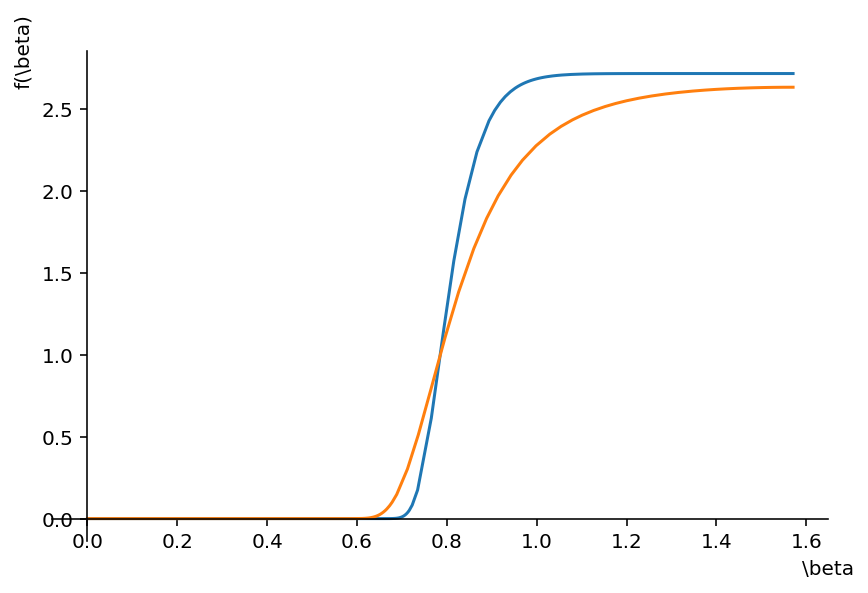

In [12]:
p1 = sy.plot(
    hillslope_tan_erosion_eqn.rhs.subs(
        {phi: pr.model.phi_h, xi_h0: 1, n_h: pr.model.n_h}
    ),
    (beta, 0, sy.pi/2),
    show=False,
)
p2 = sy.plot(
    hillslope_sin_erosion_eqn.rhs.subs(
        {phi: pr.model.phi_h, xi_h0: 1, n_h: pr.model.n_h}
    ),
    (beta, 0, sy.pi/2),
    show=False,
)
p1.extend(p2)
p1.show()
Eq(phi, (pr.model.phi_h).n())

In [13]:
model_ = pr.model.beta_type
if model_=="tan":
    hillslope_erosion_eqn = hillslope_tan_erosion_eqn
elif model_=="sin":
    hillslope_erosion_eqn = hillslope_sin_erosion_eqn
else:
    print("Not implemented")

### Fundamental function $\mathcal{F}_*$ and Hamiltonian $\mathcal{H}$

Convert the erosion model into a fundamental function $\mathcal{F}_*$ and thereby obtain the geomorphic Hamiltonian $\mathcal{H}$.

First, write the surface-normal erosion speed in terms of the surface-normal slowness covector $\mathbf{p}$.

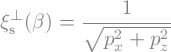

In [14]:
xih_pxpz_eqn = Eq(xi_h(beta), 1/sqrt(px**2+pz**2))
xih_pxpz_eqn

Equate this with erosion model reparameterized using covector components instead of surface angle $\beta$

In [15]:
hillslope_erosion_eqn

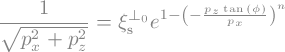

In [16]:
hillslope_pxpz_eqn = (
    hillslope_erosion_eqn
        .subs(e2d(xih_pxpz_eqn))
        .subs({tan(beta):(-px/pz)})
        .subs({sin(beta):(px/sqrt(px**2+pz**2))})
)
hillslope_pxpz_eqn

/Aside/

Note that the latter equation can be rerranged into an anisotropic eikonal equation:

\begin{equation}
    \|\mathbf{p}\|_{L2} = \left(
        \xi^{\perp_0} \exp\!\left[
            1 - \left(\dfrac{\sin\phi}{\sin\beta(\mathbf{p})}\right)^n
        \right]
    \right)^{-1}
\end{equation}

This equation says that the normal slowness of the erosion front is a function of its orientation. The nature of this orientational dependence (not simply elliptical) is what makes this eikonal equation non-classical, likely (pseudo-)Finsler, and possibly non-convex.

Note also that with the co-metric tensor $g_*(\mathbf{p})$ for this "erosion manifold", we can measure the length of the slowness covector on this manifold, which takes the simple form:

\begin{equation}
    \|\mathbf{p}\|_{g_*} = 1
\end{equation}

where $\|\cdot\|_{g_*}$ is the norm induced by the inner product defined by $g_*$ on the cotangent manifold . This automatically means that the lengths of ray vectors – as measured on the tangent manifold – are constant too:

\begin{equation}
    \|\mathbf{v}\|_{g} = 1
\end{equation}

assuming that the $g_*$ is a proper metric tensor and can be inverted to give $g = (g_*)^{-1}$.
Paths traversed by unit-length tangent vectors are, by definition, geodesics.


/End aside/

Perform the Okubo substitution $\mathbf{p} \mapsto \mathbf{p}/\mathcal{F}_*$ and rearrange to get an equation for the fundamental function $\mathcal{F}_*$

In [17]:
Fstar_hillslope_pxpz_eqn = Eq(
    Fstar,
    solve(simplify(hillslope_pxpz_eqn.subs({px: px/Fstar, pz: pz/Fstar})), Fstar)[
        0
    ],
)
Fstar_hillslope_pxpz_eqn

Convert $\mathcal{F}_*$ into the quadratic Hamiltonian $\mathcal{H}$

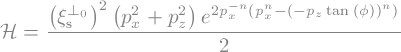

In [18]:
H_hillslope_pxpz_eqn = Eq(H, Fstar_hillslope_pxpz_eqn.rhs**2 / 2)
H_hillslope_pxpz_eqn

Check Euler homogeneity: order 1 for $\mathcal{F}_*$ and order 2 for $\mathcal{H}$

In [19]:
simplify(
    ( Fstar_hillslope_pxpz_eqn.rhs.subs({px:lmbda*px, pz:lmbda*pz})/
      Fstar_hillslope_pxpz_eqn.rhs ).subs({n_h:10})
)  

In [20]:
simplify(
    ( H_hillslope_pxpz_eqn.rhs.subs({px:lmbda*px, pz:lmbda*pz})/
      H_hillslope_pxpz_eqn.rhs ).subs({n_h:10})
)  

### Hamilton's equations and ray velocity angle $\alpha$

Derive Hamilton's ray tracing equations in the usual way.

The rate of change of the slowness covector $\dot{\mathbf{p}} = 0$, since the Hamiltonian is independent of position $\mathbf{r}$. 

As a result, ***all rays are straight lines*** that carry with them, unchanged, their initial surface slope.

The rate of change of the position vector, aka the ray velocity vector, is ${\mathbf{v}} = \dot{\mathbf{r}} = \dfrac{\mathrm{d}\mathbf{r}}{\mathrm{d}t}$, which is:

In [21]:
dHdpx = simplify(diff(H_hillslope_pxpz_eqn.rhs,px))
dHdpz = simplify(diff(H_hillslope_pxpz_eqn.rhs,pz))

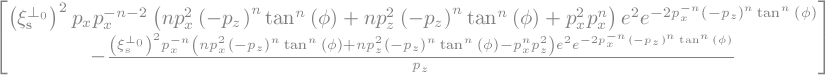

In [22]:
v_pxpz_eqn = Eq(
    Matrix([rdotx, rdotz]),
    Matrix(
        [
            factor(dHdpx),
            factor(dHdpz),
        ]
    )
)
Matrix([
    v_pxpz_eqn.rhs[0],
    v_pxpz_eqn.rhs[1],
])


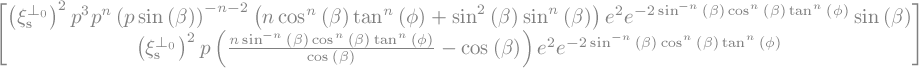

In [23]:
v_p_beta_eqn = (
    trigsimp( v_pxpz_eqn.subs({px:p*sin(beta), pz:-p*cos(beta)}) )
)
Matrix([
    v_p_beta_eqn.rhs[0], v_p_beta_eqn.rhs[1], 
])


The direction of this vector lies as an angle $\alpha$ from horizontal, so we can write $\tan\alpha$ in terms of covector $\mathbf{p}$ components

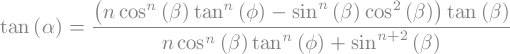

In [24]:
tanalpha_eqn = simplify(Eq(
    tan(alpha),
    trigsimp( v_p_beta_eqn.rhs[1]/v_p_beta_eqn.rhs[0] )
))
tanalpha_eqn

### Co-(semi-)metric tensor $g_*$

The co-metric (or possibly co-semi-metric) tensor $g_*$ is given by the matrix of second-order partial derivatives of the Hamiltonian with respect to the covector $\mathbf{p}$, i.e., its Hessian. 

We already have the partial derivatives of $\mathcal{H}$ with respect to the covector components $p_x$ and $p_z$:

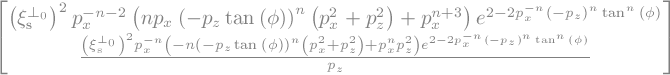

In [25]:
Matrix([dHdpx,dHdpz])

So the three second order derivatives are:

In [26]:
d2Hdpx2 = simplify(diff(dHdpx,px))
d2Hdpxpz = simplify(diff(dHdpx,pz))
d2Hdpz2 = simplify(diff(dHdpz,pz))

and thus we have the Hessian of $\mathcal{H}$, which we tentatively call the co-metric tensor $g_*$:

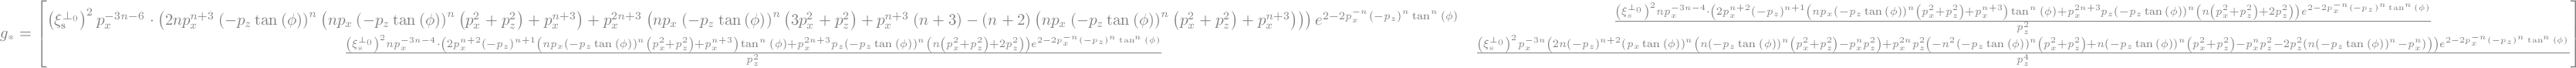

In [27]:
gstar_eqn = Eq(gstar, Matrix([[d2Hdpx2, d2Hdpxpz], [d2Hdpxpz,d2Hdpz2]]))
gstar_eqn

### Choose some parameters

Set some demo parameter values so we can check some equations.

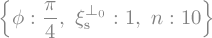

In [28]:
n_h_ = pr.model.n_h#Rational(1,2) 
phi_ = pr.model.phi_h
xi_h0_ = pr.model.xi_h0
beta_ = np.pi/5
sub_ = {xi_h0:xi_h0_, n_h:n_h_, phi:phi_}
sub_

### Figuratrix

The figuratrix is the locus of the normal-slowness covector for unit speed. The fundamental function gives us this figuratrix as a function implicit in the covector components $p_x, p_z$.

In [29]:
Fstar_hillslope_pxpz_eqn

So the figuratrix, in polar form $f(p(\beta))=1$, is

In [30]:
fgtx_raw_eqn = simplify(
    Fstar_hillslope_pxpz_eqn
        .subs({Fstar:1})
        .subs({px:p*sin(beta), pz:-p*cos(beta)})
)
fgtx_raw_eqn

which we can rearrange into a function for slowness $p(\beta)$:

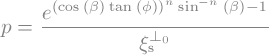

In [31]:
fgtx_p_beta_eqn = Eq(
    p,
    solve( fgtx_raw_eqn, p )[0]
)
fgtx_p_beta_eqn

which then gives the slowness covector components $p_x(\beta), p_z(\beta)$:

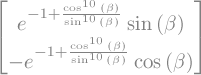

In [32]:
p_covec_fn_ = Matrix([
    (fgtx_p_beta_eqn.rhs*sin(beta)).subs(sub_),
    (-fgtx_p_beta_eqn.rhs*cos(beta)).subs(sub_)
])
# sy.plot_parametric( px_fn,pz_fn, (beta,0.2,sy.pi/3) );
p_covec_fn_

In [33]:
px_lmbda_ = lambdify([beta], p_covec_fn_[0])
pz_lmbda_ = lambdify([beta], p_covec_fn_[1])
p_lmbda_ = lambdify([beta], sqrt(p_covec_fn_[0]**2+p_covec_fn_[1]**2))
px_lmbda_(beta_), pz_lmbda_(beta_), p_lmbda_(beta_)

In [34]:
xirt_lmbda_ = lambda beta_: 1/px_lmbda_(beta_)
xiup_lmbda_ = lambda beta_: 1/pz_lmbda_(beta_)
xirt_lmbda_(beta_), xiup_lmbda_(beta_)

In [35]:
xix_lmbda_ = lambda beta_: px_lmbda_(beta_)/p_lmbda_(beta_)**2
xiz_lmbda_ = lambda beta_: pz_lmbda_(beta_)/p_lmbda_(beta_)**2
xix_lmbda_(beta_), xiz_lmbda_(beta_)

Check conjugacy – by solving for $p$ in $\mathbf{p}(\mathbf{v})=1$ and theh comparing the resulting equation with that of the figuratrix equation for $p$:

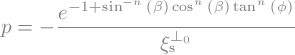

In [36]:
p_conjugate_beta_eqn = Eq(
    p,
    powsimp(solve(
        simplify(
            Eq(
                (v_p_beta_eqn.rhs[0] * px + v_p_beta_eqn.rhs[1] * pz).subs(
                    {px: p*sin(beta), pz: -p*cos(beta)}
                ),
                1,
            )
        ),
        p,
    )[0]),
)
p_conjugate_beta_eqn


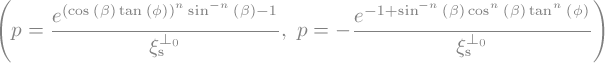

In [37]:
fgtx_p_beta_eqn, p_conjugate_beta_eqn

### Indicatrix

The indicatrix is the locus of the velocity vector for unit speed. We can get it from Hamilton's equations if we are happy to have the ray velocity components $\mathbf{v}^x,\mathbf{v}^z$ written in terms of the covector slowness magnitude $p$ and orientation $\beta$:

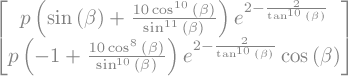

In [38]:
v_vec_fn_ =  simplify(v_p_beta_eqn.rhs.subs(sub_))
v_vec_fn_

We can eliminate the explicit dependence on $p$ by using the figuratrix equations for the components of $\mathbf{p}$ in terms of $\beta$, so that we have the indicatrix equations as function of $\beta$:

In [39]:
vx_lmbda_ = lambdify(
    [beta],
    v_vec_fn_[0].subs({p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}),
)
vz_lmbda_ = lambdify(
    [beta],
    v_vec_fn_[1].subs({p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}),
)
v_lmbda_ = lambdify(
    [beta],
    sqrt(v_vec_fn_[0] ** 2 + v_vec_fn_[1] ** 2).subs(
        {p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}
    ),
)
vx_lmbda_(beta_), vz_lmbda_(beta_), v_lmbda_(beta_)


We can now explicitly check (at a chosen demo angle $\beta$) whether these equations for $\mathbf{p}(\beta)$ and $\mathbf{v}(\beta)$ are conjugate:

In [40]:
vx_lmbda_(beta_)*px_lmbda_(beta_) + vz_lmbda_(beta_)*pz_lmbda_(beta_)

### Convexity/concavity and critical angle(s) $\beta_{\mathrm{crit}}$

The determinant of the co-metric tensor, aka the Hessian of $\mathcal{H}$, must be non-singular if we wish to Legendre transform from the Hamiltonian to the Lagrangian, i.e., if we want to obtain the dual metric tensor $g$. What's more, if the determinant is not positive, $g_*$ is not positive-definite, which means that it is not a true metric tensor, and the Hamiltonian is not convex. 

So, by finding the angle(s) at which the Hessian determinant is zero, we identify where the Hamiltonian switches from convex to non-convex (aka concave) behaviour.  This is the goal below.

The convexity and concavity of $\mathcal{H}$ are reflected in the shape of the figuratrix: curvature towards the origin indicates convexity, while curvature away from it indicates concavity, and therefore the chance of multivalued behaviour. The same applies to the Lagrangian $\mathcal{L}$ (which we don't attempt to derive in this notebook) and to the corresponding indicatrix.

The neatest way to get the determinant of $g_*$ is to use the SymPy call $\det()$, but its output is structured in a subtly different way to a direct calculation. This difference makes simplification more tricky, so we opt for the direct approach:

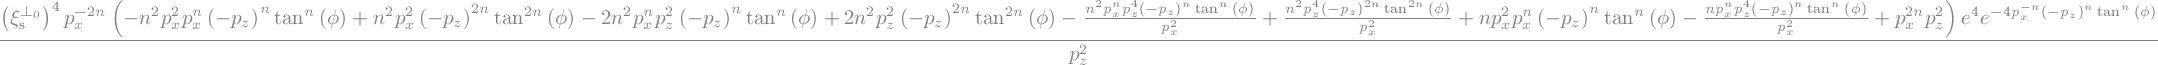

In [41]:
# H_detHessian = factor(sy.det(gstar_eqn.rhs))
H_detHessian = factor( d2Hdpx2*d2Hdpz2 - d2Hdpxpz*d2Hdpxpz )
H_detHessian

Now for some hacking. The expression above for the Hessian determinant is cumbersome, and we are only (for now) interested in its zeroes, so we extract the big term in brackets by simply cutting it out. To do so we have to know which "argument" of the above SymPy expression corresponds to the bracketed term, and it turns out to be the 5th argument for $\sin$ models and the 3rd argument for $\tan$ models:

In [42]:
selected_part_H_detHessian_ = 4 if pr.model.beta_type=="sin" else 3

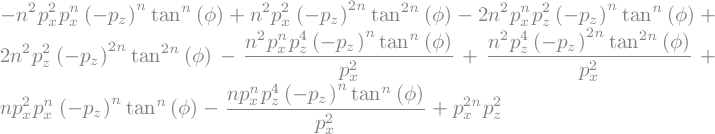

In [43]:
H_detHessian.args[selected_part_H_detHessian_]

If we substitute $\tan\beta = -p_x/p_z$, we should be able to entirely eliminate any dependence on the slowness covector components, but in practice SymPy is not very good at simplifying exponents, so some brute force manipulation is required. For clarity, we replace $\tan\beta$ with the symbol $t$ – which is emphatically NOT time. For the $\sin$ model, we also replace the sharpness exponent $n$ with $2m$, where $m$ is assumed to be a positive integer, such that $n$ is an even positive integer; this makes simplification easier.

In [44]:
if pr.model.beta_type=="sin":
    H_critical_t_eqn = Eq(expand(expand((
        simplify(
            simplify(
                factor(
                    H_detHessian.args[selected_part_H_detHessian_].subs(
                        {px: -pz*tan(beta)}
                    )
                ).subs({pz: -pzp})
            )/ (pzp**(4*n_h+6)*tan(beta)**(2*n_h-2) / cos(beta)**6)
        )).subs({Abs(cos(beta)**n_h):cos(beta)**n_h})
        .subs({Abs(cos(beta)**(2*n_h)):cos(beta)**(2*n_h)})
        .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
    ).subs({n_h:2*m_h, tan(beta):t_h})), 0)
else:
    H_critical_t_eqn = simplify(expand(
        H_detHessian.args[selected_part_H_detHessian_]
            .subs({px: -pz*tan(beta),pz: -pzp})
            *tan(beta)**2
            /pzp**(2*n_h+2)
    ).subs({tan(beta):t_h}))
Matrix([H_critical_t_eqn])


To find the critical angle(s), now is the appropriate moment to choose values for the sharpness exponent $n$ ($=2m$) and for the threshold angle $\phi$:

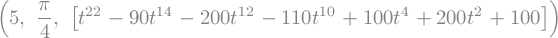

In [45]:
n_h_ = pr.model.n_h
m_h_ = n_h_//2
phi_h_ = pr.model.phi_h

H_critical_t_eqn_ = expand(
    H_critical_t_eqn.subs({n_h:n_h_, m_h:m_h_, phi:phi_h_})
)
m_h_, phi_h_, Matrix([
    H_critical_t_eqn_
])

We now have a polynomial in $t=\tan\beta$ whose roots are the critical angles of $\mathcal{H}$ at which its Hessian is singular. 

In [46]:
H_critical_t_poly_ = sy.poly(H_critical_t_eqn_,t_h)
Matrix([H_critical_t_poly_])

Find these roots numerically:

In [47]:
tanbeta_crits_ = sorted([
    float(root_)
    for root_ in H_critical_t_poly_.nroots()
    if Abs(im(root_)) < 1e-10 and re(root_) > 0
])
beta_crits_ = [np.arctan(tanbeta_crit_) for tanbeta_crit_ in tanbeta_crits_]
beta_crits_, [np.rad2deg(beta_crit_) for beta_crit_ in beta_crits_]

### Check metric signatures

The signs of the eigenvalues of the determinant of $g_*$ define what's called the *metric signature*. 

For a true metric tensor, $g_*$ must be positive definite, meaning the eigenvalues should both be positive and the signature (2,0,0) or [+,+]. This is equivalent to saying $\mathcal{H}$ is convex.

For a semi-metric tensor, $g_*$ has one or more negative eigenvalues and e.g. the signature (1,1,0) or alternatively [-,+] or [-,+]. This is equivalent to saying $\mathcal{H}$ is non-convex or concave.

If any of the eigenvalues are zero, the determinant is singular and $g_*$ is not invertible; in this case $g_*$ is indefinite and its signature is e.g. (1,1,0) aka one positive, one zero.
This is the case at each of the critical surface angles $\{\beta_{\mathrm{crit}}\}$.

We assume below (plot of figuratrix etc) that each critical angle marks a transition from convexity to concavity, or the reverse, in the Hamiltonian. To check this assertion, we calculate the metric signature at example values of $\beta$ between the critical values:

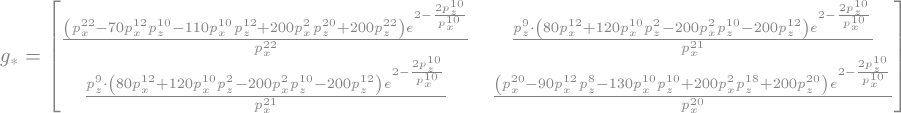

In [48]:
gstar_eqn_ = simplify( gstar_eqn.subs(sub_) )
gstar_eqn_

In [49]:
def get_gstar_signature():
    for betas_ in list(zip([0]+beta_crits_, beta_crits_+[np.pi/2])):
        bias = 0.9
        beta_  = betas_[0]*(1-bias) + betas_[1]*bias
        px_ = px_lmbda_(beta_)
        pz_ = pz_lmbda_(beta_)
        gstar_ = gstar_eqn_.rhs.subs({px:px_, pz:pz_})
        gstar_eigenvals_ = gstar_.eigenvals(multiple=True)
        gstar_signature_ = [np.sign(ev_) for ev_ in gstar_eigenvals_]
        yield(betas_, gstar_signature_)

Compute the signature for each span of $\beta$, writing simply as a tuple of signs:

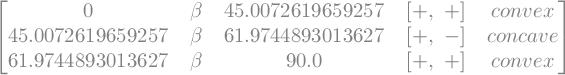

In [50]:
pos_ev: Symbol = Symbol(r"+", real=True)
neg_ev: Symbol = Symbol(r"-", real=True)
Matrix(
    [
        (
            np.rad2deg(sig_info[0][0]),
            beta,
            np.rad2deg(sig_info[0][1]),
            [pos_ev if sig_==1 else neg_ev for sig_ in sig_info[1]],
            "convex" if sig_info[1] == [1, 1] else "concave",
        )
        for sig_info in get_gstar_signature()
    ]
)

# Plot

### Prep

In [51]:
gr = GraphingBase()

In [52]:
beta_array = np.linspace(0.01,np.pi/2*1,500)
px_array = px_lmbda_(beta_array) 
pz_array = pz_lmbda_(beta_array)
vx_array = vx_lmbda_(beta_array)
vz_array = vz_lmbda_(beta_array)
p_array = np.sqrt(px_array**2+pz_array**2)
v_array = np.sqrt(vx_array**2+vz_array**2)

In [53]:
beta_array = beta_array[np.isfinite(vx_array)]
px_array = px_array[np.isfinite(vx_array)]
pz_array = pz_array[np.isfinite(vx_array)]

p_array = p_array[np.isfinite(vx_array)]
v_array = v_array[np.isfinite(vx_array)]

vz_array = vz_array[np.isfinite(vx_array)]
vx_array = vx_array[np.isfinite(vx_array)]

phi_str = str(pr.model.phi_h).replace("pi","$\pi$")

In [54]:
xix_array = px_array/p_array**2
xiz_array = pz_array/p_array**2
xirt_array = 1/px_array
xiup_array = 1/pz_array

In [55]:
markers_ = pr.plot.idtx_fgtx_zero_marker + pr.plot.idtx_fgtx_markers

def patch_idtx_fgtx_markers():
    n_beta_crit = len(beta_crits_)
    for angle_markup_ in markers_:
        if "beta_crit" in angle_markup_["angle"]:
            for idx, beta_crit_ in enumerate(beta_crits_):
                patched_angle_markup_ = angle_markup_.copy()
                patched_angle_markup_["angle"] = sy.parse_expr(
                    angle_markup_["angle"].replace("beta_crit", f"{beta_crit_}")
                ).n()
                patched_angle_markup_["label"] = angle_markup_["label"].replace(
                    "=beta_crit", (f"({idx+1})" if n_beta_crit>1 else "")
                    +f"={np.rad2deg(beta_crit_):0.1f}"
                )
                patched_angle_markup_["marker"] = angle_markup_["marker"][
                    min((idx, 1))
                ]
                yield(patched_angle_markup_)
        else:
            patched_angle_markup_ = angle_markup_.copy()
            patched_angle_markup_["angle"] = sy.parse_expr(
                angle_markup_["angle"].replace("phi_h", f"{pr.model.phi_h}")
            ).n()
            patched_angle_markup_["label"] = angle_markup_["label"].replace(
                "=phi_h", f"={np.rad2deg(float(pr.model.phi_h)):0.1f}"
            )
            yield(patched_angle_markup_)

idtx_fgtx_markers_ = sorted(
    list(patch_idtx_fgtx_markers()),
    key=lambda angle_markup: angle_markup["angle"],
)

def mark_angles(x_lmbda_, z_lmbda_, p_or_v=0, do_skip_beta0=False):
    for angle_markup_ in reversed(idtx_fgtx_markers_):
        if do_skip_beta0 and "\\rightarrow 0" in angle_markup_["label"]:
            continue
        angle_ = angle_markup_["angle"]
        plt.plot(
            x_lmbda_(float(angle_)),
            z_lmbda_(float(angle_)),
            angle_markup_["marker"],
            color=angle_markup_["colors"][p_or_v],
            label=angle_markup_["label"],
            ms=angle_markup_["size"],
        )            
# idtx_fgtx_markers_

In [56]:
def plot_segments(x_array, y_array, label_fn=None, do_v=False):
    label_fn_ = (lambda x: f"{x}") if label_fn is None else label_fn
    prev_beta_crit_ = 0
    colors_ = (
        (
            "DarkRed",
            "red",
            "darkorange",
        )
        if do_v
        else (
            "DarkBlue",
            "blue",
            "blueviolet",
        )
    )
    line_styles_ = (
        "-",
        "-.",
        "-",
    )
    is_in_range = lambda array_, range_: (
        array_ >= range_[0]) & (array_ <= range_[1]
    )
    for beta_crit_, color_, ls_, concave_or_convex in zip(
        (beta_crits_ + [np.pi / 2]),
        colors_,
        line_styles_,
        ("convex", "concave", "convex"),
    ):
        plt.plot(
            x_array[(is_in_range(beta_array, (prev_beta_crit_, beta_crit_)))],
            y_array[(is_in_range(beta_array, (prev_beta_crit_, beta_crit_)))],
            color=color_,
            linestyle=ls_,
            label=label_fn_(concave_or_convex),
        )
        prev_beta_crit_ = beta_crit_


### Erosion rate (speed) vs surface angle $\xi^{\perp}(\beta)$

gmplib.plot.GraphingBase:
   Creating plot: hillslope_tanbeta_phi45p0_n10_speed size=(8, 5) @ 100 dpi
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral


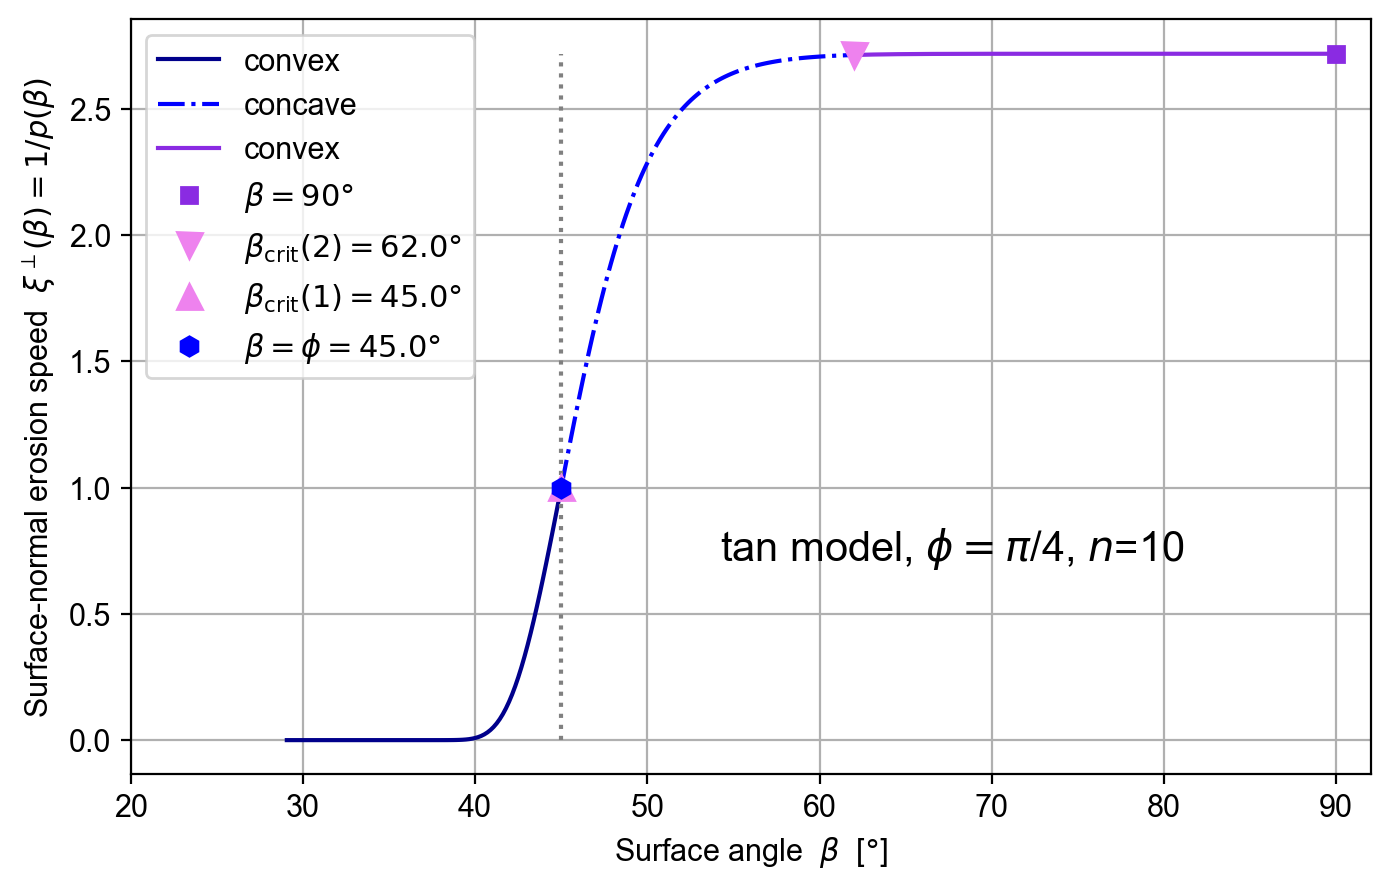

In [57]:
gr.create_figure(fig_name="_".join([job_name, "speed"]), fig_size=(8,5))
if beta_crits_ is not None:
    plot_segments(np.rad2deg(beta_array), 1/p_array)
plt.xlabel(r"Surface angle  $\beta$  [$\degree$]")
plt.ylabel(r"Surface-normal erosion speed  $\xi^{\perp}(\beta) = 1/p(\beta)$")
plt.xlim(-2 if pr.model.n_h==1 and pr.model.beta_type=="tan" else 20,92)

axes = plt.gca()
plt.text(
    *(0.85,0.3),
    rf"{pr.model.beta_type} model, " + rf"$\phi=${phi_str}, " + rf"$n$={pr.model.n_h}",
    horizontalalignment="right",
    verticalalignment="center",
    transform=axes.transAxes,
    fontsize=15,
)
phi_deg_ = np.rad2deg(float(pr.model.phi_h.n()))
plt.plot( (phi_deg_, phi_deg_,), (0,1/p_array[-1],), color='grey', ls=":" );
beta_lambda_ = lambda beta_: np.rad2deg(beta_)
xi_lmbda_ = lambda beta_: 1/p_lmbda_(beta_)
mark_angles(beta_lambda_, xi_lmbda_, p_or_v=0, 
    do_skip_beta0=(pr.model.beta_type=="sin" or pr.model.n_h>1))
plt.grid(":")
plt.legend(); #loc=pr.plot.fgtx_legend_loc);

### Normal-speed $\mathcal{F}_*(\xi^x, \xi^z)=1$  figuratrix

gmplib.plot.GraphingBase:
   Creating plot: hillslope_tanbeta_phi45p0_n10_xi_figuratrix size=(8, 8) @ 100 dpi
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode


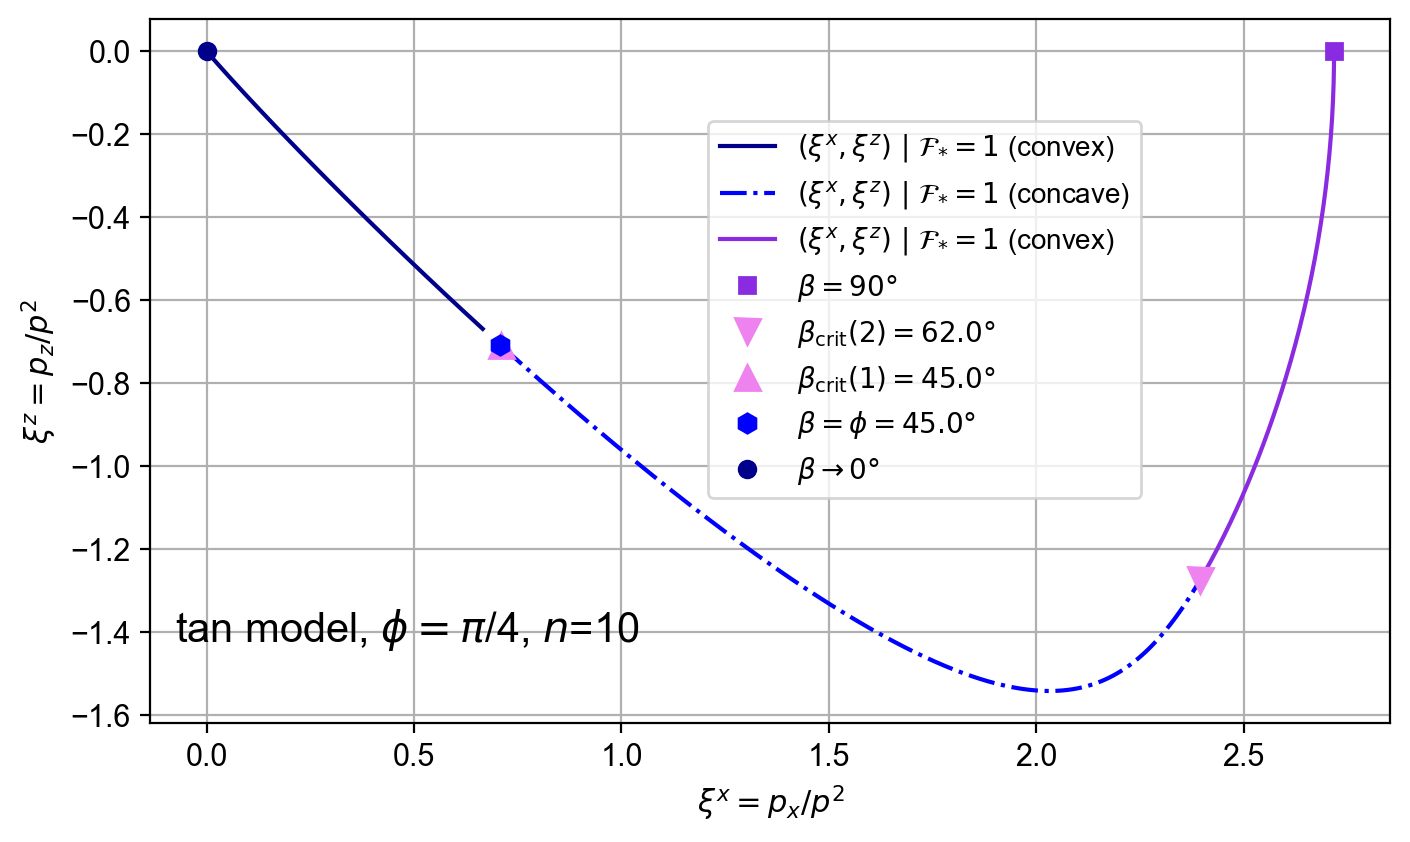

In [58]:
gr.create_figure(fig_name="_".join([job_name, "xi_figuratrix"]))
label_fn_ = (
    lambda x: r"$(\xi^x,\xi^z) \,\,|\,\,\mathcal{F}_{*}=1$ "+ f"({x})"
)
plot_segments(xix_array, xiz_array, label_fn=label_fn_)
plt.xlabel(r"$\xi^x = p_x/p^2$")
plt.ylabel(r"$\xi^z =p_z/p^2$")
mark_angles(xix_lmbda_, xiz_lmbda_, p_or_v=0)
axes = plt.gca()
axes.set_aspect(1)
plt.text(
    *(0.02,0.1),
    rf"{pr.model.beta_type} model, "
    + rf"$\phi=${phi_str}, "
    + rf"$n$={pr.model.n_h}",
    horizontalalignment="left",
    verticalalignment="bottom",
    transform=axes.transAxes,
    fontsize=15,
)
plt.grid(":")
plt.legend(loc=(0.45,0.32), fontsize=10);

### Normal-speed $\mathcal{F}_*(\xi^{\to}, \xi^{\downarrow})=1$  figuratrix

gmplib.plot.GraphingBase:
   Creating plot: hillslope_tanbeta_phi45p0_n10_recipp_figuratrix size=(8, 8) @ 100 dpi
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode


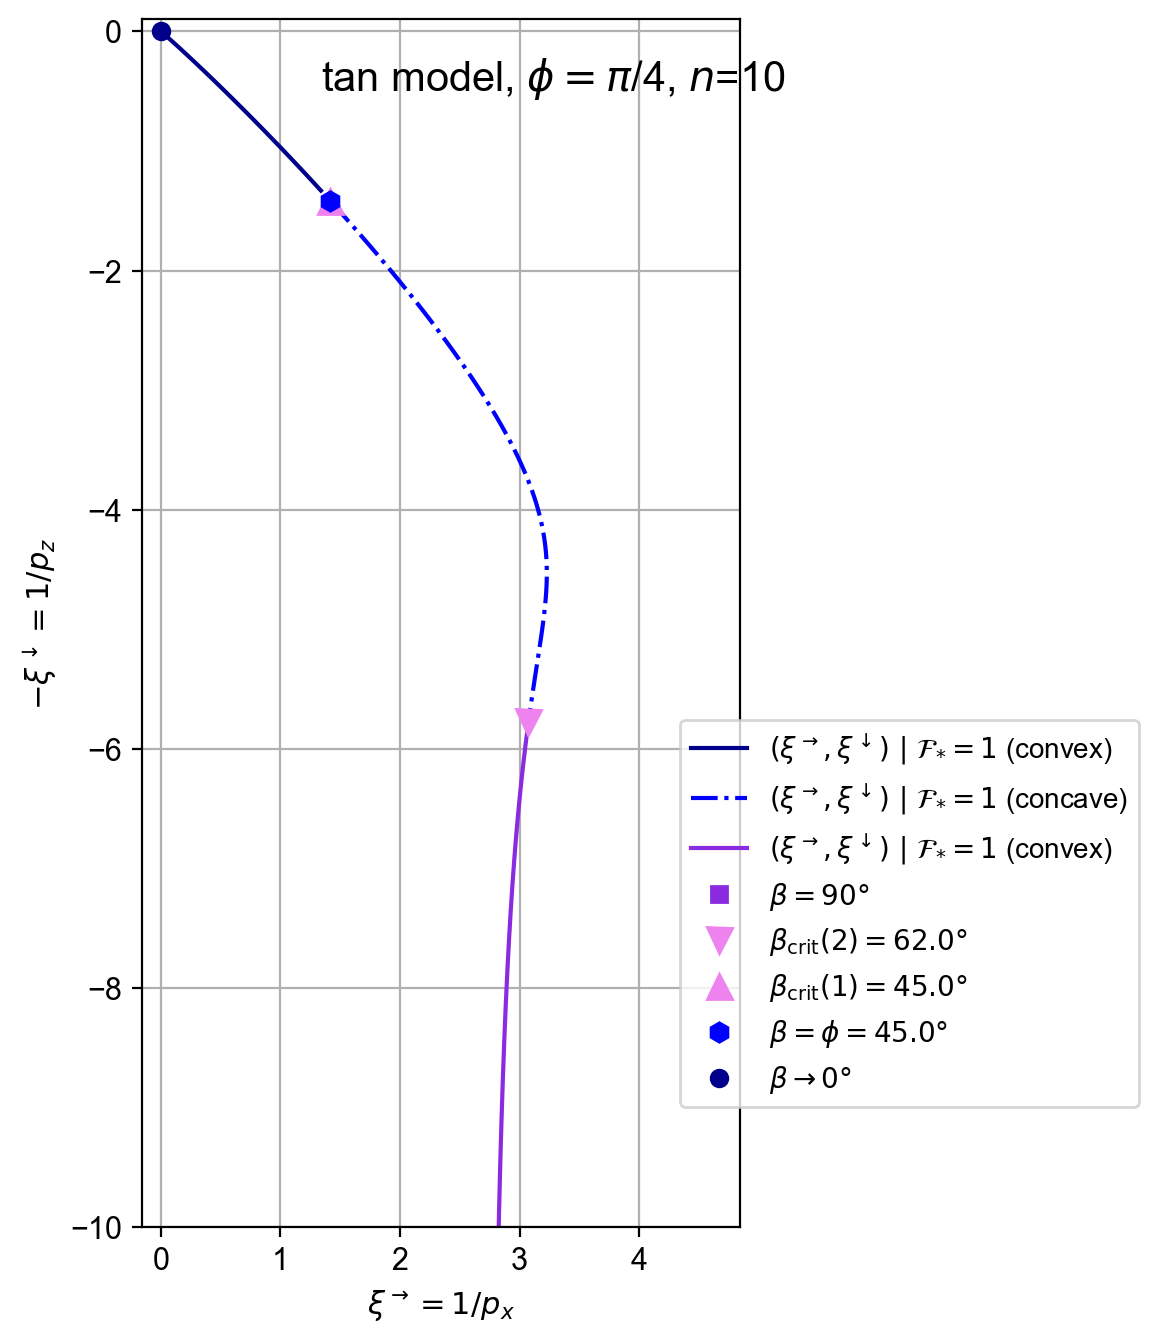

In [59]:
gr.create_figure(fig_name="_".join([job_name, "recipp_figuratrix"]))
label_fn_ = (
    lambda x: r"$(\xi^{\rightarrow},\xi^{\downarrow}) \,\,|\,\, \mathcal{F}_{*}=1$ "+ f"({x})"
)
plot_segments(xirt_array, xiup_array, label_fn=label_fn_)
plt.xlabel(r"$\xi^{\rightarrow} = 1/p_x$")
plt.ylabel(r"$-\xi^{\downarrow} = 1/p_z$")
mark_angles(xirt_lmbda_, xiup_lmbda_, p_or_v=0)
# if pr.plot.fgtx_xlim is not None:
#     plt.xlim(*pr.plot.fgtx_xlim)
# if pr.plot.fgtx_ylim is not None:
#     plt.ylim(*pr.plot.fgtx_ylim)
plt.xlim(None,np.max(xirt_array)*1.5)
plt.ylim(-10,0.1)
axes = plt.gca()
axes.set_aspect(1)
plt.text(
    *(0.3,0.97),
    rf"{pr.model.beta_type} model, "
    + rf"$\phi=${phi_str}, "
    + rf"$n$={pr.model.n_h}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=axes.transAxes,
    fontsize=15,
)
plt.grid(":")
plt.legend(loc=(0.9,0.1), fontsize=10);

### Normal-slowness $\mathcal{F}_*(p_x,p_z)=1$  figuratrix

Plot the figuratrix, marking the convex and concave segments in different shades of blue. The curve extends to $p_z\rightarrow-\infty$ for $\beta\rightarrow 0$.

gmplib.plot.GraphingBase:
   Creating plot: hillslope_tanbeta_phi45p0_n10_p_figuratrix size=(8, 8) @ 100 dpi
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode


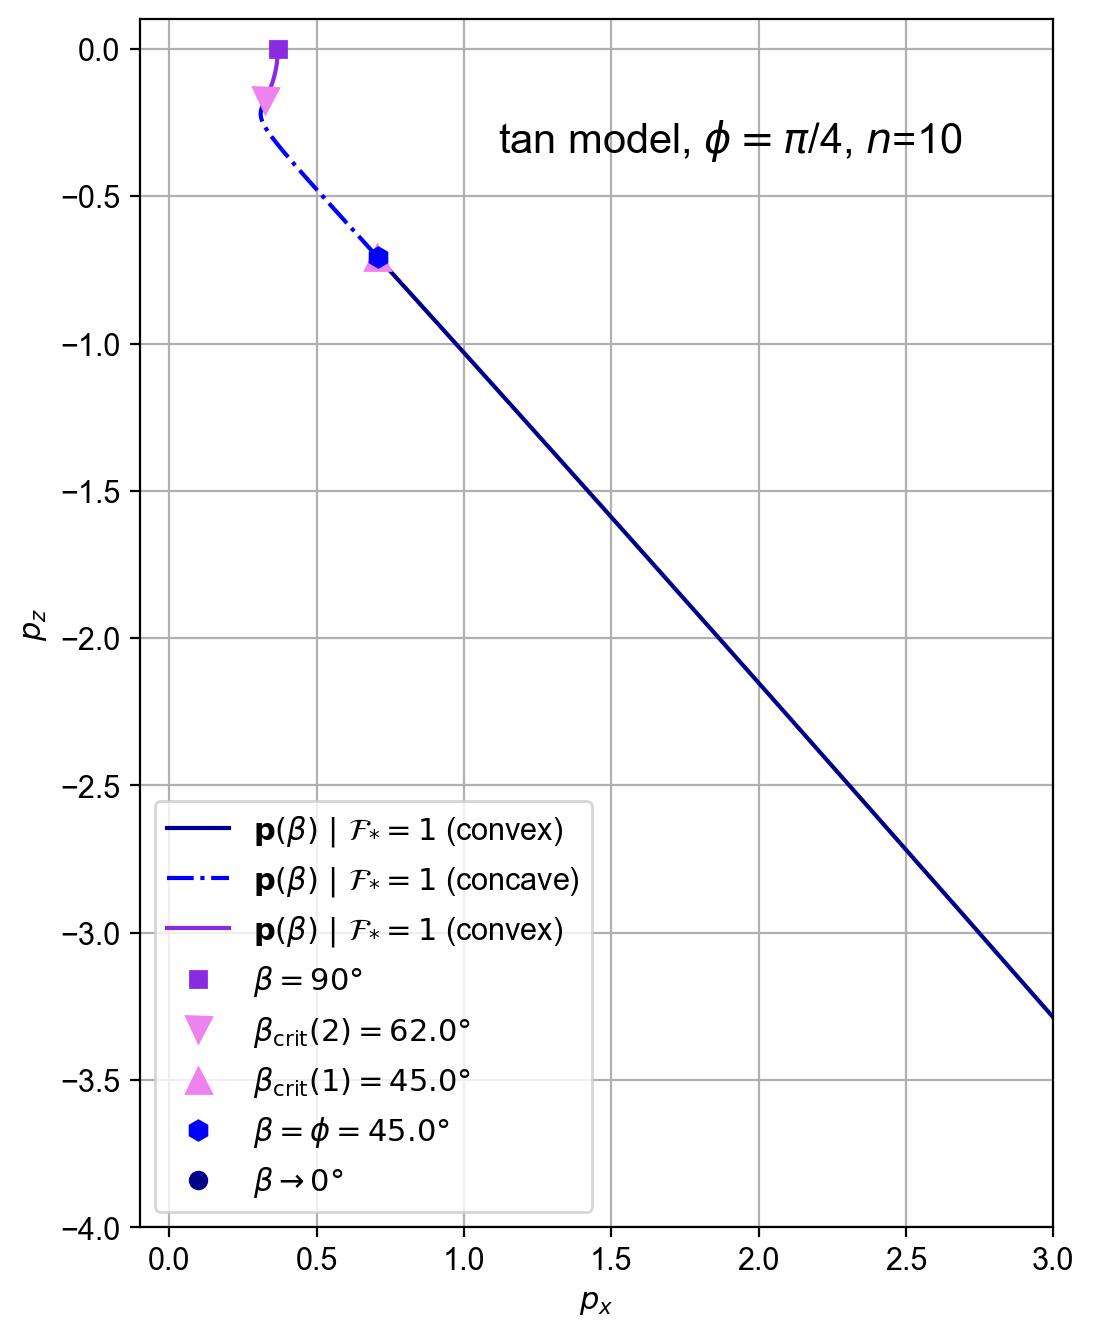

In [60]:
gr.create_figure(fig_name="_".join([job_name, "p_figuratrix"]))
label_fn_ = (
    lambda x: r"$\mathbf{p}(\beta) \,\,|\,\,\mathcal{F}_{*}=1$ "+ f"({x})"
)
plot_segments(px_array, pz_array, label_fn=label_fn_)
plt.xlabel(r"$p_x$")
plt.ylabel(r"$p_z$")
mark_angles(px_lmbda_, pz_lmbda_, p_or_v=0)
if pr.plot.fgtx_xlim is not None:
    plt.xlim(*pr.plot.fgtx_xlim)
if pr.plot.fgtx_ylim is not None:
    plt.ylim(*pr.plot.fgtx_ylim)
axes = plt.gca()
axes.set_aspect(1)
plt.text(
    *pr.plot.fgtx_label_loc,
    rf"{pr.model.beta_type} model, "
    + rf"$\phi=${phi_str}, "
    + rf"$n$={pr.model.n_h}",
    horizontalalignment="right",
    verticalalignment="center",
    transform=axes.transAxes,
    fontsize=15,
)
plt.grid(":")
plt.legend(loc=pr.plot.fgtx_legend_loc);

### Ray speed $\mathcal{F}(v^x, v^z)=1$ indicatrix

Plot the indicatrix, marking the convex and concave segments in different shades of red. Computation of $v$ is unstable for $\beta\rightarrow 0$, so behaviour towards the origin is approximate (but too small to see) here.

gmplib.plot.GraphingBase:
   Creating plot: hillslope_tanbeta_phi45p0_n10_v_indicatrix size=(8, 8) @ 100 dpi
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode


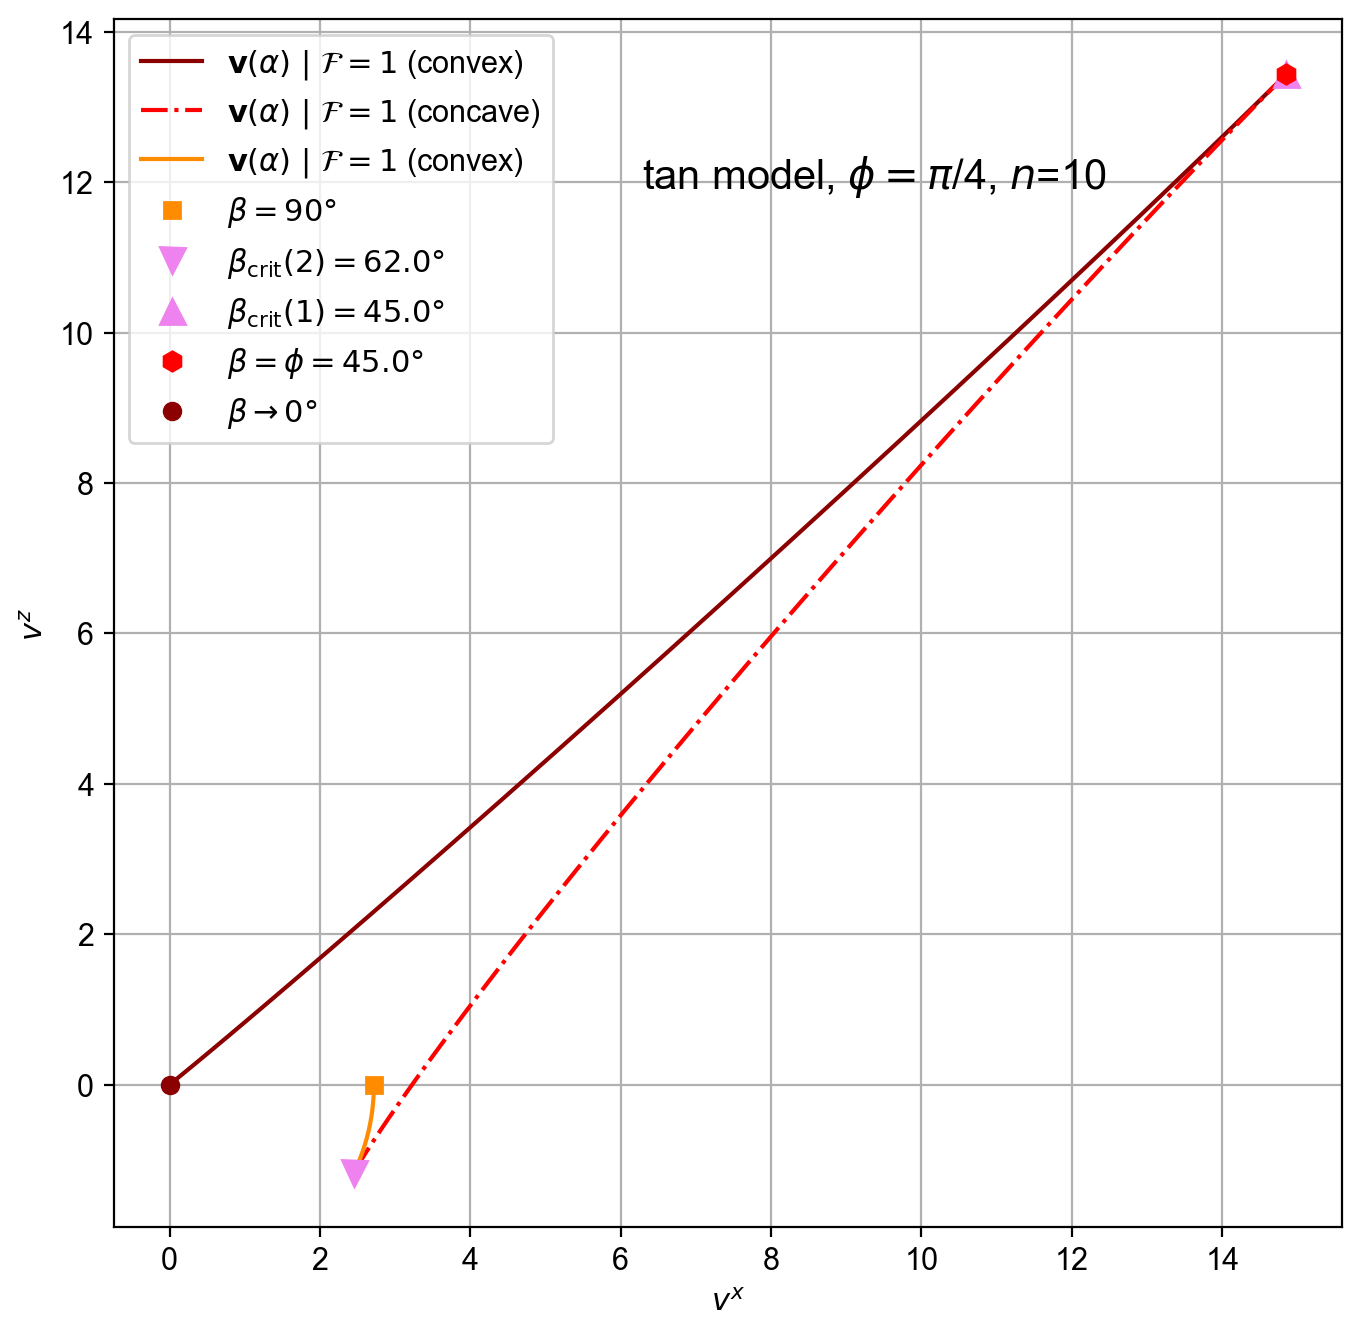

In [61]:
gr.create_figure(fig_name="_".join([job_name, "v_indicatrix"]))
label_fn_ = (
    lambda x: r"$\mathbf{v}(\alpha) \,\,|\,\,\mathcal{F}=1$ "+ f"({x})"
)
plot_segments(vx_array, vz_array, label_fn=label_fn_, do_v=True)
plt.xlabel(r"$v^x$")
plt.ylabel(r"$v^z$")
mark_angles(vx_lmbda_, vz_lmbda_, p_or_v=1)
if pr.plot.idtx_xlim is not None:
    plt.xlim(*pr.plot.idtx_xlim)
if pr.plot.idtx_ylim is not None:
    plt.ylim(*pr.plot.idtx_ylim)
axes = plt.gca()
axes.set_aspect(1)
plt.text(
    *pr.plot.idtx_label_loc,
    rf"{pr.model.beta_type} model, " + rf"$\phi=${phi_str}, " + rf"$n$={pr.model.n_h}",
    horizontalalignment="left",
    verticalalignment="center",
    transform=axes.transAxes,
    fontsize=15,
)
plt.grid(":")
plt.legend(loc=pr.plot.idtx_legend_loc, fontsize=pr.plot.idtx_fontsize);

# Save

In [62]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots(
    gr.fdict,
    plots_dir,
    pr.save.figs_format,
    suffix="",
    dpi=pr.save.figs_options["dpi"],
)

gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/Notes"
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
gmplib.save.export_plot: Exported "hillslope_tanbeta_phi45p0_n10_speed.jpg"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plot: Exported "hillslope_tanbeta_phi45p0_n10_xi_figuratrix.jpg"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plot: Exported "hillslope_tanbeta_phi45p0_n10_recipp_figuratrix.jpg"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from S